In [1]:
from airflow import DAG
from airflow.operators.python import PythonOperator, BranchPythonOperator
from airflow.operators.bash import BashOperator

import os
import requests
from datetime import datetime
import json
import pandas as pd
import configparser

import psycopg2 as ps 
from sqlalchemy import create_engine  

import matplotlib.pyplot as oPlot

from datetime import datetime, timedelta

import spotipy
from spotipy.oauth2 import SpotifyOAuth
import logging

import numpy as np

from sqlalchemy.exc import IntegrityError

import seaborn as sns


## Folders and targets
# AIRFLOW_HOME = os.environ['AIRFLOW_HOME']
# config = configparser.ConfigParser()
# config.read(AIRFLOW_HOME + '/airflow.cfg')
# AIRFLOW_DAGS = config.get('core', 'dags_folder')
# CURR_DIR_PATH = os.path.dirname(os.path.realpath(__file__))


# # Spotify API credentials # Later we can create a config file to hide the below credentials
# client_id = '7ac4100bc0f84e978f1b4c8e4b74576b'
# client_secret = '62fed3a94a224ef48272a7b3d8ea0583'
# redirect_uri = 'http://localhost:8888/callback'
# scope = 'user-read-recently-played'


# ## Function to download the json data from API and save the data in json format to SPOTIFY_JSON_TARGET
# def _download_from_spotify_api():
#     # Set up logging
#     logging.basicConfig(level=logging.INFO)

#     # Initialize Spotipy with Spotify credentials
#     sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
#                                                 client_secret=client_secret,
#                                                 redirect_uri=redirect_uri,
#                                                 scope=scope))
    
#     # Calculate yesterday's midnight in Unix timestamp (milliseconds) 
#     yesterday_midnight = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=1) 
#     yesterday_midnight_unix = int(yesterday_midnight.timestamp() * 1000) 
#     logging.info(f"Yesterday's midnight in Unix timestamp (milliseconds): {yesterday_midnight_unix}")
    
#     # Fetch recently played tracks
#     results = sp.current_user_recently_played(limit=50)

#     # Save raw JSON data
#     with open('recently_played_tracks_raw.json', 'w', encoding='utf-8') as f:
#         json.dump(results, f, ensure_ascii=False, indent=4)
#     logging.info("Raw data saved to recently_played_tracks_raw.json")
    
#     # Convert JSON to DataFrame and save as CSV
#     df = pd.json_normalize(results['items'])  # Flatten the JSON structure to create a table
#     df.to_csv('recently_played_tracks_raw.csv', index=False)
#     logging.info("Raw data saved to recently_played_tracks_raw.csv")



## Prepare the data and save it in csv format to SPOTIFY_PREPARED_CSV
def prepare_listening_date_dataframe():
    # Load the CSV into a DataFrame
    df = pd.read_csv('/home/meeriforslund/my_project/airflow/graduationproject/recently_played_tracks_raw.csv')

    # Ensure the 'played_at' column is in datetime format
    df['date_time'] = pd.to_datetime(df['played_at'])

    # Extract hour, weekday, week of year, month number, month name, quarter, and year
    df['hour'] = df['date_time'].dt.hour
    df['weekday'] = df['date_time'].dt.day_name()
    df['week_of_year'] = df['date_time'].dt.isocalendar().week
    df['month_num'] = df['date_time'].dt.month
    df['month_name'] = df['date_time'].dt.month_name()
    df['quarter'] = df['date_time'].dt.quarter
    df['year'] = df['date_time'].dt.year

    # Determine if the day is a weekend
    df['weekend'] = np.where(df['weekday'].isin(['Saturday', 'Sunday']), 'Yes', 'No')

    # Changing date_time column to only contain the date in date format
    df['date_time'] = df['date_time'].dt.date

    # Select only the columns relevant for the listening_date table
    listening_date_df = df[['date_time', 'hour', 'weekday', 'week_of_year', 'month_num', 'month_name', 'quarter', 'year', 'weekend']]

    return listening_date_df


def _prepare_data():
    df = pd.read_csv('/home/meeriforslund/my_project/airflow/graduationproject/recently_played_tracks_raw.csv')
    
    columns_to_drop = [
        'context', 
        'track.album.artists', 
        'track.album.available_markets', 
        'track.album.uri',
        'track.album.href', 
        'track.album.id', 
        'track.album.images', 
        'track.album.type', 
        'track.album.release_date_precision',
        'track.available_markets', 
        'track.disc_number', 
        'track.explicit', 
        'track.external_ids.isrc', 
        'track.external_urls.spotify',
        'track.href', 
        'track.is_local', 
        'track.preview_url', 
        'track.track_number', 
        'track.type', 
        'track.album.external_urls.spotify',
        'track.id',
        'track.uri'
    ]

    df.drop(columns=columns_to_drop, inplace=True)

    df['track.duration_ms'] = df['track.duration_ms'] / 1000
    df.rename(columns={'track.duration_ms': 'track.duration_sec'}, inplace=True)

    def parse_artists(artists_str):
        try:
            # Parse the JSON-like string into a Python list
            artists = json.loads(artists_str.replace("'", '"'))
            # Extract artist names
            artist_names = [artist['name'] for artist in artists]
            return artist_names
        except (json.JSONDecodeError, TypeError):
            # Handle any errors that occur during parsing
            return []

    # Apply the parsing function to the 'track.artists' column
    df['artist_names'] = df['track.artists'].apply(parse_artists)

    

    listening_date_dataframe = prepare_listening_date_dataframe()

    # played_at column no longer needed after its extracted to other dataframe
    # df.drop(columns=['played_at'], inplace=True)
    df.drop(columns=['played_at'], inplace=True)
    df.drop(columns=['track.artists'], inplace=True)

    # Combine the two DataFrames side by side (column-wise)
    combined_data = pd.concat([df, listening_date_dataframe], axis=1)

    combined_data.rename(columns={'track.album.album_type': 'album_type'}, inplace=True)
    combined_data.rename(columns={'track.album.name': 'album_name'}, inplace=True)
    combined_data.rename(columns={'track.album.release_date': 'release_date'}, inplace=True)
    combined_data.rename(columns={'track.album.total_tracks': 'total_tracks'}, inplace=True)
    combined_data.rename(columns={'track.duration_sec': 'track_lenght'}, inplace=True)
    combined_data.rename(columns={'track.popularity': 'popularity'}, inplace=True)
    combined_data.rename(columns={'artist_names': 'artist'}, inplace=True)
    combined_data.rename(columns={'track.name': 'track_name'}, inplace=True)

    # Change the type of artist columns contents to strings, round the track_lenght, change the date_time to date
    combined_data['artist'] = combined_data['artist'].apply(lambda x: str(x) if isinstance(x, list) else x)
    combined_data['track_lenghts'] = combined_data['track_lenght'].round(0)
    combined_data['date_time'] = pd.to_datetime(combined_data['date_time']).dt.date
    combined_data.rename(columns={'date_time': 'dates'}, inplace=True)
    
    # Save the combined DataFrame to a new CSV file
    combined_data.to_csv('combined_spotify.csv', index=False)






def execute_sql_commands():
    # Connect to the database using psycopg2
    conn = ps.connect(dbname="meeriforslund", user="meeriforslund", port=5433)
    cur = conn.cursor()

    # List of SQL commands to execute
    sql_commands = [
        """
CREATE TABLE IF NOT EXISTS public.tracks
(
    track_id serial NOT NULL,
    track_name text,
    length_id integer,
    date_id integer,
    album_id integer,
    popularity_id integer,
    artist_id integer,
    PRIMARY KEY (track_id)
);

        """,
        """
CREATE TABLE IF NOT EXISTS public.album
(
    album_id serial NOT NULL,
    album_name text,
    album_type text,
    total_tracks integer,
    release_date date,
    PRIMARY KEY (album_id)
);
        """,
        """
CREATE TABLE IF NOT EXISTS public.listening_date
(
    date_id serial NOT NULL,
    dates date,
    hour integer,
    weekday text,
    week_of_year integer,
    month_num integer,
    month_name text,
    quarter integer,
    year integer,
    weekend text,
    PRIMARY KEY (date_id)
);
        """,
        """
CREATE TABLE IF NOT EXISTS public.artists
(
    artist_id serial NOT NULL,
    artist text,
    PRIMARY KEY (artist_id)
);
        """,
        """
CREATE TABLE IF NOT EXISTS public.popularity
(
    popularity_id serial NOT NULL,
    popularity integer,
    PRIMARY KEY (popularity_id)
);
        """,
        """
CREATE TABLE IF NOT EXISTS public.lengths
(
    length_id serial NOT NULL,
    track_lenght integer,
    PRIMARY KEY (length_id)
);
        """,
        """
ALTER TABLE IF EXISTS public.tracks
    ADD CONSTRAINT tracks_listening_date FOREIGN KEY (date_id)
    REFERENCES public.listening_date (date_id) MATCH SIMPLE
    ON UPDATE NO ACTION
    ON DELETE NO ACTION
    NOT VALID;
        """,
        """
ALTER TABLE IF EXISTS public.tracks
    ADD CONSTRAINT tracks_album FOREIGN KEY (album_id)
    REFERENCES public.album (album_id) MATCH SIMPLE
    ON UPDATE NO ACTION
    ON DELETE NO ACTION
    NOT VALID;
        """,
        """
ALTER TABLE IF EXISTS public.tracks
    ADD CONSTRAINT tracks_popularity FOREIGN KEY (popularity_id)
    REFERENCES public.popularity (popularity_id) MATCH SIMPLE
    ON UPDATE NO ACTION
    ON DELETE NO ACTION
    NOT VALID;
        """,
        """
ALTER TABLE IF EXISTS public.tracks
    ADD CONSTRAINT tracks_artists FOREIGN KEY (artist_id)
    REFERENCES public.artists (artist_id) MATCH SIMPLE
    ON UPDATE NO ACTION
    ON DELETE NO ACTION
    NOT VALID;
        """,
        """
ALTER TABLE IF EXISTS public.tracks
    ADD CONSTRAINT track_length FOREIGN KEY (length_id)
    REFERENCES public.lengths (length_id) MATCH SIMPLE
    ON UPDATE NO ACTION
    ON DELETE NO ACTION
    NOT VALID;
        """
    ]

    # Execute each SQL command
    for command in sql_commands:
        cur.execute(command)

    # Commit the changes to the database
    conn.commit()

    # Close the cursor and the connection
    cur.close()
    conn.close()

def postgres_creator():  # sqlalchemy requires callback-function for connections
  return ps.connect(
            dbname="meeriforslund",  # name of schema
            user="meeriforslund",
            port=5433
        #   password=db_pw,
        #   port=5432,          # default port is 5432, but can be specified
        #   host="localhost"
    )


# Connect to the PostgreSQL database
postgres_engine = create_engine(
    url="postgresql+psycopg2://localhost",  # driver identification + dbms api
    creator=postgres_creator  # connection details
)



def _stage():
    # Ensure that tables exist by running SQL commands
    execute_sql_commands()

    # Path to the combined CSV file
    combined_data_path = 'combined_spotify.csv'

    # Read the data from the combined CSV file
    combined_data = pd.read_csv(combined_data_path)


    # Prepare individual DataFrames for each table
    tracks_df = combined_data[['track_name', 'album_name', 'artist', 'popularity', 'track_lenght', 'dates']].copy()
    # tracks_df = combined_data[['track_name']]
    album_df = combined_data[['album_name', 'album_type', 'total_tracks', 'release_date']].drop_duplicates()
    listening_date_df = combined_data[['dates', 'hour', 'weekday', 'week_of_year', 'month_num', 'month_name', 'quarter', 'year', 'weekend']].drop_duplicates()
    artists_df = combined_data[['artist']].drop_duplicates()
    popularity_df = combined_data[['popularity']].drop_duplicates()
    lengths_df = combined_data[['track_lenght']].drop_duplicates()

    # Insert data to tables that dont have foreing keys
    album_df.to_sql(name="album", con=postgres_engine, if_exists="append", index=False)
    listening_date_df.to_sql(name="listening_date", con=postgres_engine, if_exists="append", index=False)
    artists_df.to_sql(name="artists", con=postgres_engine, if_exists="append", index=False)
    popularity_df.to_sql(name="popularity", con=postgres_engine, if_exists="append", index=False)
    lengths_df.to_sql(name="lengths", con=postgres_engine, if_exists="append", index=False)

    # Load data from the foreign key tables to get the IDs
    album_ids = pd.read_sql_table('album', con=postgres_engine)[['album_id', 'album_name']]
    artists_ids = pd.read_sql_table('artists', con=postgres_engine)[['artist_id', 'artist']]
    popularity_ids = pd.read_sql_table('popularity', con=postgres_engine)[['popularity_id', 'popularity']]
    lengths_ids = pd.read_sql_table('lengths', con=postgres_engine)[['length_id', 'track_lenght']]
    listening_date_ids = pd.read_sql_table('listening_date', con=postgres_engine)[['date_id', 'dates']]

    # Ensure that both 'dates' columns are of the same type
    tracks_df['dates'] = pd.to_datetime(tracks_df['dates'])
    listening_date_ids['dates'] = pd.to_datetime(listening_date_ids['dates'])

    # Map names/values to their respective IDs
    tracks_df = tracks_df.merge(album_ids, how='left', on='album_name')
    tracks_df = tracks_df.merge(artists_ids, how='left', on='artist')
    tracks_df = tracks_df.merge(popularity_ids, how='left', on='popularity')
    tracks_df = tracks_df.merge(lengths_ids, how='left', on='track_lenght')
    tracks_df = tracks_df.merge(listening_date_ids, how='left', on='dates')

    # Prepare the final DataFrame for the tracks table
    tracks_final_df = tracks_df[['track_name', 'length_id', 'date_id', 'album_id', 'popularity_id', 'artist_id']].copy()

    # Insert data into the tracks table
    tracks_final_df.to_sql(name='tracks', con=postgres_engine, if_exists='append', index=False)

## Modeling part starts here:

1. Track Popularity

    Scatter Plot:
    
        - Purpose: Analyze the relationship between track popularity and track length.

        - A scatter plot is created using seaborn.scatterplot().
        
        - A trend line (linear regression) is added to the scatter plot using seaborn.regplot().

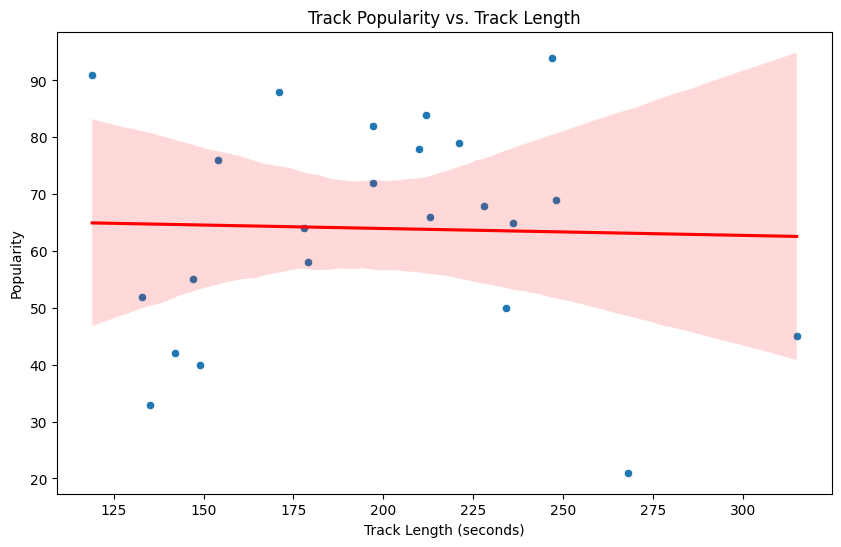

In [2]:
import pandas as pd
import psycopg2 as ps
import seaborn as sns
import matplotlib.pyplot as plt

def fetch_data():
    # Connect to PostgreSQL database
    conn = ps.connect(dbname="meeriforslund", user="meeriforslund", port=5433)
    cur = conn.cursor()

    # Fetch track lengths
    cur.execute("SELECT track_lenght FROM lengths;")
    track_lengths = cur.fetchall()

    # Fetch popularity
    cur.execute("SELECT popularity FROM popularity;")
    popularity = cur.fetchall()

    cur.close()
    conn.close()

    # Convert to DataFrame
    track_lengths_df = pd.DataFrame(track_lengths, columns=['track_length'])
    popularity_df = pd.DataFrame(popularity, columns=['popularity'])

    return track_lengths_df, popularity_df

def create_scatter_plot():
    track_lengths_df, popularity_df = fetch_data()

    # Combine data for plotting
    combined_df = pd.concat([track_lengths_df, popularity_df], axis=1)

    # Create a scatter plot with trend line
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x='track_length', y='popularity', data=combined_df)

    # Optional: Add a trend line
    sns.regplot(x='track_length', y='popularity', data=combined_df, scatter=False, color='red')

    # Customize the plot
    plt.title('Track Popularity vs. Track Length')
    plt.xlabel('Track Length (seconds)')
    plt.ylabel('Popularity')

    plt.show()

# Run the function to plot the scatter plot
create_scatter_plot()


2. Listening Time of Day

    Heatmap:
        
        - Purpose: Show what time of day you listen to music most often.
        - The cmap='YlGnBu' argument defines the color map, and annot=True displays the actual counts on the heatmap.

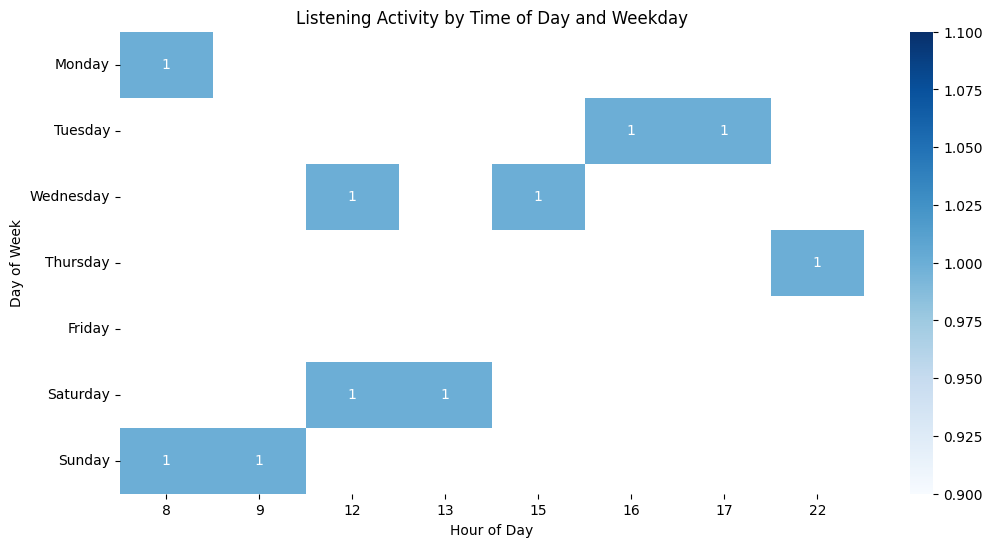

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as ps

def fetch_listening_data():
    # Connect to PostgreSQL database
    conn = ps.connect(dbname="meeriforslund", user="meeriforslund", port=5433)
    cur = conn.cursor()

    # Fetch hour and weekday from the listening_date table
    cur.execute("""
    SELECT hour, weekday FROM listening_date;
    """)
    
    # Fetch data and convert to DataFrame
    data = cur.fetchall()
    df = pd.DataFrame(data, columns=['hour', 'weekday'])

    cur.close()
    conn.close()

    return df

def create_heatmap():
    # Fetch the listening data
    df = fetch_listening_data()

    # Group by hour and weekday, counting the number of occurrences (i.e., number of tracks played)
    grouped_df = df.groupby(['hour', 'weekday']).size().reset_index(name='count')

    # Pivot the data to create a matrix (weekday as rows, hour as columns)
    pivot_df = grouped_df.pivot(index='weekday', columns='hour', values='count')

    # Reorder the weekday for better readability (starting with Monday)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_df = pivot_df.reindex(weekday_order)

    # Create the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, cmap='Blues', annot=True)

    # Customize the plot
    plt.title('Listening Activity by Time of Day and Weekday')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')

    plt.show()

# Run the function to create the heatmap
create_heatmap()


3. Top Tracks

    Bar Chart:

        - Purpose: Highlight your most frequently played tracks.

/tmp/ipykernel_804849/4013030535.py:35 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

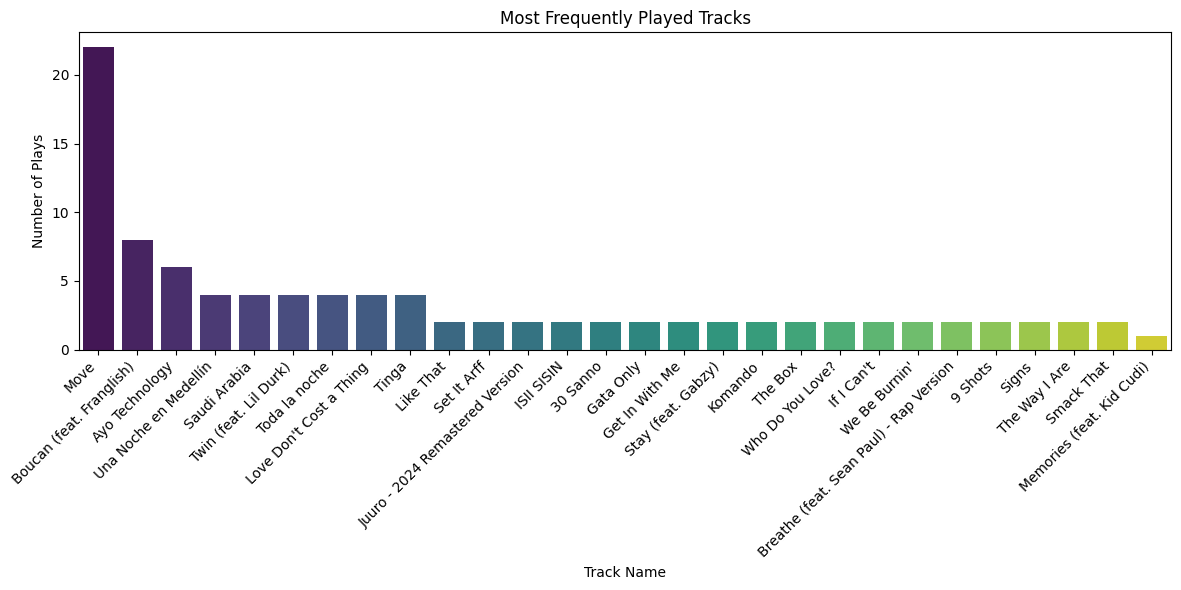

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as ps

def fetch_track_play_data():
    # Connect to PostgreSQL database
    conn = ps.connect(dbname="meeriforslund", user="meeriforslund", port=5433)
    cur = conn.cursor()

    # Fetch track names from the tracks table
    cur.execute("""
    SELECT track_name FROM tracks;
    """)

    # Fetch data and convert to DataFrame
    data = cur.fetchall()
    df = pd.DataFrame(data, columns=['track_name'])

    cur.close()
    conn.close()

    return df

def create_bar_chart():
    # Fetch the track play data
    df = fetch_track_play_data()

    # Group by track_name and count the number of times each track was played
    track_counts = df['track_name'].value_counts().reset_index()
    track_counts.columns = ['track_name', 'number_of_plays']

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='track_name', y='number_of_plays', data=track_counts, palette='viridis')

    # Customize the plot
    plt.title('Most Frequently Played Tracks')
    plt.xlabel('Track Name')
    plt.ylabel('Number of Plays')
    
    # Rotate track names on X-axis for better readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Run the function to create the bar chart
create_bar_chart()

4. Release Year Distribution

    Histogram:

        - Purpose: Show the distribution of track release years.

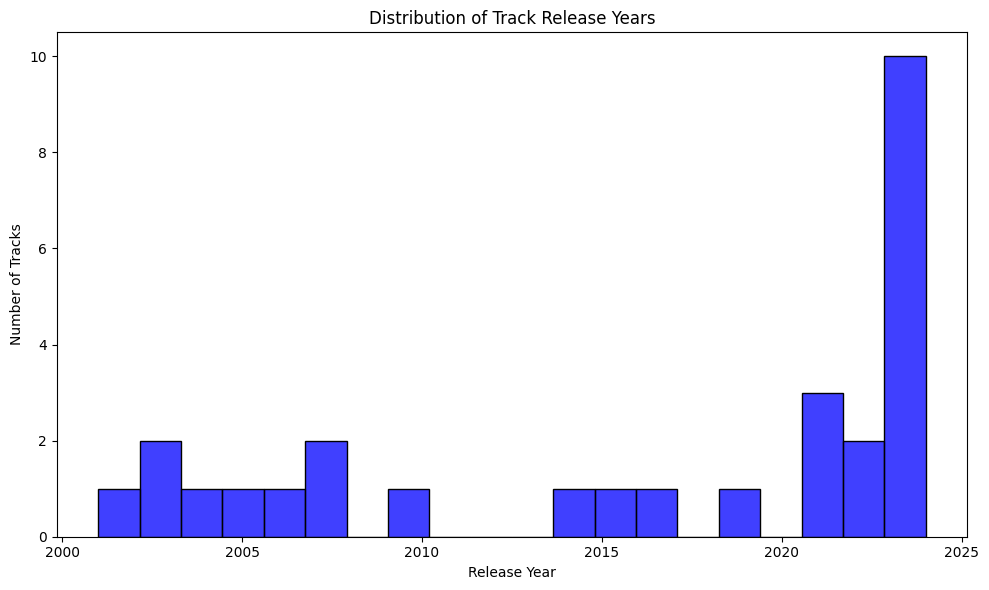

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as ps

def fetch_release_year_data():
    # Connect to PostgreSQL database
    conn = ps.connect(dbname="meeriforslund", user="meeriforslund", port=5433)
    cur = conn.cursor()

    # Fetch release dates from the album table
    cur.execute("""
    SELECT release_date FROM album;
    """)

    # Fetch data and convert to DataFrame
    data = cur.fetchall()
    df = pd.DataFrame(data, columns=['release_date'])

    cur.close()
    conn.close()

    # Extract the year from the release_date column
    df['release_year'] = pd.to_datetime(df['release_date']).dt.year

    return df

def create_histogram():
    # Fetch the release year data
    df = fetch_release_year_data()

    # Create a histogram to show the distribution of release years
    plt.figure(figsize=(10, 6))
    sns.histplot(df['release_year'], bins=20, kde=False, color='blue')

    # Customize the plot
    plt.title('Distribution of Track Release Years')
    plt.xlabel('Release Year')
    plt.ylabel('Number of Tracks')

    plt.tight_layout()
    plt.show()

# Run the function to create the histogram
create_histogram()
